### 0 loading libs & competition data

In [2]:
import pandas as pd    
%run cfcs.py

In [3]:
riskfutures = pd.read_csv('Data/corn_climate_risk_futures_daily_master.csv')
marketshare = pd.read_csv('Data/corn_regional_market_share.csv')
## dir need to change before submission to Kaggle input directories

#### Note: EDAs were done seperately.

### 1 Baseline Feature Engineering

In [4]:
mergedf = riskfutures.copy()
mergedf['day_of_year'] = pd.to_datetime(mergedf['date_on'],format='%Y-%m-%d').dt.dayofyear
mergedf['quarter'] = pd.to_datetime(mergedf['date_on'],format='%Y-%m-%d').dt.quarter

In [5]:
mergedf = mergedf.merge(marketshare[['region_id','percent_country_production']],how='left',on='region_id')

In [6]:
mergedf['percent_country_production'] = mergedf['percent_country_production'].fillna(0.0)
## see EDA_regional_marketshare.ipynb

#### New Climate Features Risks

In [7]:
# Total cnt locations for each rows
mergedf['total_location_by_region'] = mergedf['climate_risk_cnt_locations_heat_stress_risk_low'] + \
                                    mergedf['climate_risk_cnt_locations_heat_stress_risk_medium'] + \
                                    mergedf['climate_risk_cnt_locations_heat_stress_risk_high']

# Climate Risk for Coldwave, and Flood:
for i in range(1, 5):
    mergedf[f'medium_coldstress_lag_{i}'] = mergedf['climate_risk_cnt_locations_unseasonably_cold_risk_medium'].shift(i)
    mergedf[f'medium_precip_lag_{i}'] = mergedf['climate_risk_cnt_locations_excess_precip_risk_medium'].shift(i)
    
    mergedf[f'medium_coldstress_lag_{i}'] = mergedf[f'medium_coldstress_lag_{i}'].fillna(0)
    mergedf[f'medium_precip_lag_{i}'] = mergedf[f'medium_precip_lag_{i}'].fillna(0)

for j in range(1, 3): 
    mergedf[f'high_coldstress_lag_{j}'] = mergedf['climate_risk_cnt_locations_unseasonably_cold_risk_high'].shift(j)
    mergedf[f'high_precip_lag_{j}'] = mergedf['climate_risk_cnt_locations_excess_precip_risk_high'].shift(j)

    mergedf[f'high_coldstress_lag_{j}'] = mergedf[f'high_coldstress_lag_{j}'].fillna(0)
    mergedf[f'high_precip_lag_{j}'] = mergedf[f'high_precip_lag_{j}'].fillna(0)

mergedf['medium_coldstress_4days_average'] = mergedf[[f'medium_coldstress_lag_{i}' for i in range(1, 5)]].mean(axis=1)
mergedf['medium_coldstress_2days_average'] = mergedf[[f'medium_coldstress_lag_{i}' for i in range(1, 3)]].mean(axis=1)
mergedf['high_coldstress_2days_average'] = mergedf[[f'high_coldstress_lag_{i}' for i in range(1, 3)]].mean(axis=1)

mergedf['medium_precip_4days_average'] = mergedf[[f'medium_precip_lag_{i}' for i in range(1, 5)]].mean(axis=1)
mergedf['medium_precip_2days_average'] = mergedf[[f'medium_precip_lag_{i}' for i in range(1, 3)]].mean(axis=1)
mergedf['high_precip_2days_average'] = mergedf[[f'high_precip_lag_{i}' for i in range(1, 3)]].mean(axis=1)

mergedf['climate_risk_cnt_locations_coldwave_risk_high'] = (mergedf['medium_coldstress_4days_average'] + mergedf['high_coldstress_2days_average']) / 2
mergedf['climate_risk_cnt_locations_coldwave_risk_medium'] = (mergedf['medium_coldstress_2days_average'] + mergedf['high_coldstress_lag_1']) / 2

mergedf['climate_risk_cnt_locations_flood_risk_high'] = (mergedf['medium_precip_4days_average'] + mergedf['high_precip_2days_average']) / 2
mergedf['climate_risk_cnt_locations_flood_risk_medium'] = (mergedf['medium_precip_2days_average'] + mergedf['high_precip_lag_1']) / 2


#### Importers and Exporters Manual Weightings

In [8]:
supply_weights = {
    # Exporters
    "United States": 2.00, "Brazil": 1.85, "Argentina": 1.75, "Ukraine": 1.60, "Russia": 1.40, "Canada": 1.40,
    # Importers
    "China": 1.30, "Mexico": 1.25,
    # Marginal
    "South Africa": 1.20,
    # Neither
    "Paraguay": 1.10, "India": 1.05
    }

mergedf['supply_chain_weightings'] = mergedf['country_name'].map(supply_weights)

seasonal_weights = {
            'Off-season': 0.5,
            'Planting': 1,
            'Mid-season': 2,
            'Harvest': 2,
            'Peak Harvest': 2.5,
        }

mergedf['seasonality_weightings'] = mergedf['harvest_period'].map(seasonal_weights)
mergedf['adjusted_weightings'] = mergedf['supply_chain_weightings'] * mergedf['seasonality_weightings'] * mergedf['percent_country_production']

#### Weather Forecasting Score

In [9]:
mergedf['sum_of_medium_high_drought_risk'] = mergedf['climate_risk_cnt_locations_drought_risk_medium'] + mergedf['climate_risk_cnt_locations_drought_risk_high']
mergedf['sum_of_medium_high_excess_precip_risk'] = mergedf['climate_risk_cnt_locations_excess_precip_risk_medium'] + mergedf['climate_risk_cnt_locations_excess_precip_risk_high']
mergedf['sum_of_medium_high_unseasonably_cold_risk'] = mergedf['climate_risk_cnt_locations_unseasonably_cold_risk_medium'] + mergedf['climate_risk_cnt_locations_unseasonably_cold_risk_high']
mergedf['sum_of_medium_high_heat_stress_risk'] = mergedf['climate_risk_cnt_locations_heat_stress_risk_medium'] + mergedf['climate_risk_cnt_locations_heat_stress_risk_high']

mergedf['sum_of_medium_high_drought_risk_lag_1yr'] = mergedf['sum_of_medium_high_drought_risk'].shift(365)
mergedf['sum_of_medium_high_excess_precip_risk_lag_1yr'] = mergedf['sum_of_medium_high_excess_precip_risk'].shift(365)
mergedf['sum_of_medium_high_unseasonably_cold_risk_lag_1yr'] = mergedf['sum_of_medium_high_unseasonably_cold_risk'].shift(365)
mergedf['sum_of_medium_high_heat_stress_risk_lag_1yr'] = mergedf['sum_of_medium_high_heat_stress_risk'].shift(365)

mergedf['sum_of_medium_high_drought_risk_lag_1yr'] = mergedf['sum_of_medium_high_drought_risk_lag_1yr'].fillna(0)
mergedf['sum_of_medium_high_excess_precip_risk_lag_1yr'] = mergedf['sum_of_medium_high_excess_precip_risk_lag_1yr'].fillna(0)
mergedf['sum_of_medium_high_unseasonably_cold_risk_lag_1yr'] = mergedf['sum_of_medium_high_unseasonably_cold_risk_lag_1yr'].fillna(0)
mergedf['sum_of_medium_high_heat_stress_risk_lag_1yr'] = mergedf['sum_of_medium_high_heat_stress_risk_lag_1yr'].fillna(0)

mergedf['diff_drought'] = mergedf['sum_of_medium_high_drought_risk'] - mergedf['sum_of_medium_high_drought_risk_lag_1yr']
mergedf['diff_excessprecip'] = mergedf['sum_of_medium_high_excess_precip_risk'] - mergedf['sum_of_medium_high_excess_precip_risk_lag_1yr']
mergedf['diff_cold'] = mergedf['sum_of_medium_high_unseasonably_cold_risk'] - mergedf['sum_of_medium_high_unseasonably_cold_risk_lag_1yr']
mergedf['diff_heatstress'] = mergedf['sum_of_medium_high_heat_stress_risk'] - mergedf['sum_of_medium_high_heat_stress_risk_lag_1yr']

mergedf.head()

,ID,crop_name,country_name,country_code,region_name,region_id,harvest_period,growing_season_year,date_on,climate_risk_cnt_locations_heat_stress_risk_low,climate_risk_cnt_locations_heat_stress_risk_medium,climate_risk_cnt_locations_heat_stress_risk_high,climate_risk_cnt_locations_unseasonably_cold_risk_low,climate_risk_cnt_locations_unseasonably_cold_risk_medium,climate_risk_cnt_locations_unseasonably_cold_risk_high,climate_risk_cnt_locations_excess_precip_risk_low,climate_risk_cnt_locations_excess_precip_risk_medium,climate_risk_cnt_locations_excess_precip_risk_high,climate_risk_cnt_locations_drought_risk_low,climate_risk_cnt_locations_drought_risk_medium,climate_risk_cnt_locations_drought_risk_high,futures_close_ZC_1,futures_close_ZC_2,futures_close_ZW_1,futures_close_ZS_1,futures_zc1_ret_pct,futures_zc1_ret_log,futures_zc_term_spread,futures_zc_term_ratio,futures_zc1_ma_20,futures_zc1_ma_60,futures_zc1_ma_120,futures_zc1_vol_20,futures_zc1_vol_60,futures_zw_zc_spread,futures_zc_zw_ratio,futures_zs_zc_spread,futures_zc_zs_ratio,date_on_year,date_on_month,date_on_year_month,day_of_year,quarter,percent_country_production,total_location_by_region,medium_coldstress_lag_1,medium_precip_lag_1,medium_coldstress_lag_2,medium_precip_lag_2,medium_coldstress_lag_3,medium_precip_lag_3,medium_coldstress_lag_4,medium_precip_lag_4,high_coldstress_lag_1,high_precip_lag_1,high_coldstress_lag_2,high_precip_lag_2,medium_coldstress_4days_average,medium_coldstress_2days_average,high_coldstress_2days_average,medium_precip_4days_average,medium_precip_2days_average,high_precip_2days_average,climate_risk_cnt_locations_coldwave_risk_high,climate_risk_cnt_locations_coldwave_risk_medium,climate_risk_cnt_locations_flood_risk_high,climate_risk_cnt_locations_flood_risk_medium,supply_chain_weightings,seasonality_weightings,adjusted_weightings,sum_of_medium_high_drought_risk,sum_of_medium_high_excess_precip_risk,sum_of_medium_high_unseasonably_cold_risk,sum_of_medium_high_heat_stress_risk,sum_of_medium_high_drought_risk_lag_1yr,sum_of_medium_high_excess_precip_risk_lag_1yr,sum_of_medium_high_unseasonably_cold_risk_lag_1yr,sum_of_medium_high_heat_stress_risk_lag_1yr,diff_drought,diff_excessprecip,diff_cold,diff_heatstress
0,8af42722-3f05-4ede-80fc-605e0e2b3b67,Corn: Commodity Tracked,Argentina,AR,Buenos Aires,bffad37a-7c60-432f-984a-8ea83a944311,Harvest,2017,2016-06-15,23,0,0,23,0,0,23,0,0,16,7,0,429.00,434.00,477.50,1156.0,-0.017182,-0.017331,5.00,1.011655,414.4125,387.695833,375.014583,0.013520,0.015724,48.50,0.898429,727.00,0.371107,2016,6,2016_06,167,2,27.0,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.0,0.0,1.75,2.0,94.5,7,0,0,0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0
1,54f4ddc5-e7ab-4bfb-ad6a-5649841af563,Corn: Commodity Tracked,Argentina,AR,Buenos Aires,bffad37a-7c60-432f-984a-8ea83a944311,Harvest,2017,2016-06-16,23,0,0,23,0,0,23,0,0,14,9,0,425.25,430.50,472.50,1134.5,-0.008741,-0.008780,5.25,1.012346,415.7000,388.616667,375.512500,0.013799,0.015792,47.25,0.900000,709.25,0.374835,2016,6,2016_06,168,2,27.0,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.0,0.0,1.75,2.0,94.5,9,0,0,0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0
2,63a41fce-d371-4295-a58a-dc6491664020,Corn: Commodity Tracked,Argentina,AR,Buenos Aires,bffad37a-7c60-432f-984a-8ea83a944311,Harvest,2017,2016-06-17,23,0,0,14,1,8,23,0,0,14,8,1,437.75,442.75,481.25,1159.5,0.029394,0.028971,5.00,1.011422,418.0875,389.770833,376.122917,0.013442,0.016145,43.50,0.909610,721.75,0.377533,2016,6,2016_06,169,2,27.0,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.0,0.0,1.75,2.0,94.5,9,0,9,0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0
3,cddfa440-e0eb-4735-beb1-1aca2afefe53,Corn: Commodity Tracked,Argentina,AR,Buenos Aires,bffad37a-7c60-432f-984a-8ea83a944311,Harvest,2017,2016-06-18,23,0,0,20,0,3,23,0,0,15,6,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,6,2016_06,170,2,27.0,23,1.0,0.0,0.0,0

In [10]:
category = ['drought', 'excessprecip', 'cold', 'heatstress']

mergedf['worse_off_indicator'] = 0
mergedf['better_off_indicator'] = 0

for disaster in category:
    x = mergedf.loc[:, f'diff_{disaster}']

    if isinstance(x, pd.DataFrame):
        x = x.iloc[:, 0]
    
    mergedf['worse_off_indicator'] += pd.Series(1, index=x.index).where(x > 1, 0)
    mergedf['better_off_indicator'] += pd.Series(1, index=x.index).where(x < -1, 0)

mergedf.head()

,ID,crop_name,country_name,country_code,region_name,region_id,harvest_period,growing_season_year,date_on,climate_risk_cnt_locations_heat_stress_risk_low,climate_risk_cnt_locations_heat_stress_risk_medium,climate_risk_cnt_locations_heat_stress_risk_high,climate_risk_cnt_locations_unseasonably_cold_risk_low,climate_risk_cnt_locations_unseasonably_cold_risk_medium,climate_risk_cnt_locations_unseasonably_cold_risk_high,climate_risk_cnt_locations_excess_precip_risk_low,climate_risk_cnt_locations_excess_precip_risk_medium,climate_risk_cnt_locations_excess_precip_risk_high,climate_risk_cnt_locations_drought_risk_low,climate_risk_cnt_locations_drought_risk_medium,climate_risk_cnt_locations_drought_risk_high,futures_close_ZC_1,futures_close_ZC_2,futures_close_ZW_1,futures_close_ZS_1,futures_zc1_ret_pct,futures_zc1_ret_log,futures_zc_term_spread,futures_zc_term_ratio,futures_zc1_ma_20,futures_zc1_ma_60,futures_zc1_ma_120,futures_zc1_vol_20,futures_zc1_vol_60,futures_zw_zc_spread,futures_zc_zw_ratio,futures_zs_zc_spread,futures_zc_zs_ratio,date_on_year,date_on_month,date_on_year_month,day_of_year,quarter,percent_country_production,total_location_by_region,medium_coldstress_lag_1,medium_precip_lag_1,medium_coldstress_lag_2,medium_precip_lag_2,medium_coldstress_lag_3,medium_precip_lag_3,medium_coldstress_lag_4,medium_precip_lag_4,high_coldstress_lag_1,high_precip_lag_1,high_coldstress_lag_2,high_precip_lag_2,medium_coldstress_4days_average,medium_coldstress_2days_average,high_coldstress_2days_average,medium_precip_4days_average,medium_precip_2days_average,high_precip_2days_average,climate_risk_cnt_locations_coldwave_risk_high,climate_risk_cnt_locations_coldwave_risk_medium,climate_risk_cnt_locations_flood_risk_high,climate_risk_cnt_locations_flood_risk_medium,supply_chain_weightings,seasonality_weightings,adjusted_weightings,sum_of_medium_high_drought_risk,sum_of_medium_high_excess_precip_risk,sum_of_medium_high_unseasonably_cold_risk,sum_of_medium_high_heat_stress_risk,sum_of_medium_high_drought_risk_lag_1yr,sum_of_medium_high_excess_precip_risk_lag_1yr,sum_of_medium_high_unseasonably_cold_risk_lag_1yr,sum_of_medium_high_heat_stress_risk_lag_1yr,diff_drought,diff_excessprecip,diff_cold,diff_heatstress,worse_off_indicator,better_off_indicator
0,8af42722-3f05-4ede-80fc-605e0e2b3b67,Corn: Commodity Tracked,Argentina,AR,Buenos Aires,bffad37a-7c60-432f-984a-8ea83a944311,Harvest,2017,2016-06-15,23,0,0,23,0,0,23,0,0,16,7,0,429.00,434.00,477.50,1156.0,-0.017182,-0.017331,5.00,1.011655,414.4125,387.695833,375.014583,0.013520,0.015724,48.50,0.898429,727.00,0.371107,2016,6,2016_06,167,2,27.0,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.0,0.0,1.75,2.0,94.5,7,0,0,0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,1,0
1,54f4ddc5-e7ab-4bfb-ad6a-5649841af563,Corn: Commodity Tracked,Argentina,AR,Buenos Aires,bffad37a-7c60-432f-984a-8ea83a944311,Harvest,2017,2016-06-16,23,0,0,23,0,0,23,0,0,14,9,0,425.25,430.50,472.50,1134.5,-0.008741,-0.008780,5.25,1.012346,415.7000,388.616667,375.512500,0.013799,0.015792,47.25,0.900000,709.25,0.374835,2016,6,2016_06,168,2,27.0,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.0,0.0,1.75,2.0,94.5,9,0,0,0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,1,0
2,63a41fce-d371-4295-a58a-dc6491664020,Corn: Commodity Tracked,Argentina,AR,Buenos Aires,bffad37a-7c60-432f-984a-8ea83a944311,Harvest,2017,2016-06-17,23,0,0,14,1,8,23,0,0,14,8,1,437.75,442.75,481.25,1159.5,0.029394,0.028971,5.00,1.011422,418.0875,389.770833,376.122917,0.013442,0.016145,43.50,0.909610,721.75,0.377533,2016,6,2016_06,169,2,27.0,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.0,0.0,1.75,2.0,94.5,9,0,9,0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,2,0
3,cddfa440-e0eb-4735-beb1-1aca2afefe53,Corn: Commodity Tracked,Argentina,AR,Buenos Aires,bffad37a-7c60-432f-984a-8ea83a944311,Harvest,2017,2016-06-18,23,0,0,20,0,3,23,0,0,15,6,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [11]:
mergedf['forecasting_weighting_for_supply_shock'] = mergedf['worse_off_indicator'] * mergedf['adjusted_weightings']


print(mergedf['supply_chain_weightings'].isna().sum())
print(mergedf['adjusted_weightings'].isna().sum())
print(mergedf['forecasting_weighting_for_supply_shock'].isna().sum())

0
0
0


#### 1.1 Production-Weighted Risk Scores

In [12]:
risk_categories = ['heat_stress', 'unseasonably_cold', 'excess_precip', 'drought', \
                    'coldwave', 'flood']

for risk in risk_categories:
    #low = f'climate_risk_cnt_locations_{risk}_risk_low'
    medium = f'climate_risk_cnt_locations_{risk}_risk_medium'
    high = f'climate_risk_cnt_locations_{risk}_risk_high'
    
    risk_scores = (1*mergedf[medium]+2*mergedf[high])/\
                           (mergedf['total_location_by_region'])
    ## define regional daily risk score as normalized weighted sum of number of locations
    
    production_weighted_risk_scores = (risk_scores*mergedf['percent_country_production'])/100
    ## use marketshare data to get production-weighted regional daily risk scores
    
    mergedf[f'climate_risk_{risk}_score'] = risk_scores
    mergedf[f'climate_risk_{risk}_weighted_score'] = production_weighted_risk_scores
    ## iterate for all four climate risk types; total 8 new engieered features

#### 1.2 Composite Risk Indices

In [13]:
mergedf['climate_risk_temperature_stress'] = \
mergedf[[f'climate_risk_{risk}_score' for risk in risk_categories[:2]]].max(axis=1)
## maximum of temperature-related risk scores
mergedf['climate_risk_precipitation_stress'] = \
mergedf[[f'climate_risk_{risk}_score' for risk in risk_categories[2:]]].max(axis=1)
## maximum of precipitation-related risk scores
mergedf['climate_risk_overall_stress'] = \
mergedf[[f'climate_risk_{risk}_score' for risk in risk_categories]].max(axis=1)
## maximum of all risk scores
mergedf['climate_risk_avg_stress'] = \
mergedf[[f'climate_risk_{risk}_score' for risk in risk_categories]].mean(axis=1)
## average of all risk scores
## total 4 new engineered features

#### 1.3 Risk Temporal Summaries

In [14]:
mergedf = mergedf.sort_values(['region_name','date_on'])
window_period = [14,20,40,60,90,120,240]
## three periods to compute risk scores moving avg and maximum 
for window in window_period:
    for risk in risk_categories:
        mergedf[f'climate_risk_{risk}_ma_{window}d'] = \
        mergedf.groupby(['region_name'])[f'climate_risk_{risk}_score']\
               .rolling(window=window,min_periods=1).mean().reset_index(level=0,drop=True)
## compute risk score moving avg with different windows for different risk types in each region

        mergedf[f'climate_risk_{risk}_max_{window}d'] = \
        mergedf.groupby(['region_name'])[f'climate_risk_{risk}_score']\
               .rolling(window=window,min_periods=1).max().reset_index(level=0,drop=True)
## compute maximum risk scores with different windows for different risk types in each region
## total 3*4*2 = 24 new features

/var/folders/1x/j7cms8w90n71y__h4q0x74180000gn/T/ipykernel_3597/1153267851.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mergedf[f'climate_risk_{risk}_ma_{window}d'] = \
/var/folders/1x/j7cms8w90n71y__h4q0x74180000gn/T/ipykernel_3597/1153267851.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mergedf[f'climate_risk_{risk}_max_{window}d'] = \
/var/folders/1x/j7cms8w90n71y__h4q0x74180000gn/T/ipykernel_3597/1153267851.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

#### 1.4 Risk Momentum

In [15]:
features_change1d = mergedf.groupby('region_name')[[f'climate_risk_{risk}_score' for risk in risk_categories]]\
       .diff(periods=1)\
       .rename(columns=dict(zip([f'climate_risk_{risk}_score' for risk in risk_categories],\
                                [f'climate_risk_{risk}_change_1d' for risk in risk_categories])))
## Daily Change of risk scores for each risk type in each region 

features_acceleration = features_change1d.diff(periods=1)
## Acceleration of daily Change of risk scores for each risk type in each region

features_change1w = mergedf.groupby('region_name')[[f'climate_risk_{risk}_score' for risk in risk_categories]]\
       .diff(periods=7)\
       .rename(columns=dict(zip([f'climate_risk_{risk}_score' for risk in risk_categories],\
                                [f'climate_risk_{risk}_change_1d' for risk in risk_categories])))
## Weekly Change of risk scores for each risk type in each region 

mergedf = pd.concat([mergedf,\
           features_change1d,\
           features_change1w,\
           features_acceleration],axis=1)
## 12 new features in Risk Momentum category

#### 1.5 Cross-Regional features

In [16]:
feature_country = pd.concat([\
mergedf.groupby(['country_name', 'date_on'])\
[[f'climate_risk_{risk}_score' for risk in risk_categories]]\
.agg(['mean','max','std']),
## compute country-wide daily avg, max, and std risk scores
mergedf.groupby(['country_name', 'date_on'])\
[[f'climate_risk_{risk}_weighted_score' for risk in risk_categories]]\
.agg('sum')],axis=1)
## compute country-wide daily production-weighted sum risk scores
feature_country.columns = [f'climate_risk_{risk}_score_country_{metric}'\
                          for risk in risk_categories \
                          for metric in ['mean','max','std']]+\
                          [f'climate_risk_{risk}_weighted_score_country_sum'\
                          for risk in risk_categories]
## rename new features
mergedf = mergedf.merge(feature_country.reset_index(),\
              how='left',\
              on=['country_name','date_on'])
## add 4*4=16 new features

#### Non Linear Transformation
- Including Log1p, Squareroot without chaginging signs, Thresh Magnitude

In [17]:
import numpy as np

In [18]:
climate_risk_cols = [c for c in mergedf.columns if c.startswith('climate_risk_')]
for feature_name in climate_risk_cols:
    x = mergedf.loc[:, feature_name]

    if isinstance(x, pd.DataFrame):
        x = x.iloc[:, 0]
    
    mergedf[f'{feature_name}_log1p'] = np.log1p(x.clip(lower=0))
    mergedf[f'{feature_name}_log1p'] = mergedf[f'{feature_name}_log1p'].fillna(0)
    mergedf[f'{feature_name}_ssqrt'] = np.sign(x) * np.sqrt(np.abs(x))
    mergedf[f'{feature_name}_ssqrt'] = mergedf[f'{feature_name}_ssqrt'].fillna(0)
    mergedf[f'{feature_name}_thresh_mag'] = x.where(x>1, 0)
    mergedf[f'{feature_name}_thresh_mag'] = mergedf[f'{feature_name}_thresh_mag'].fillna(0)

/var/folders/1x/j7cms8w90n71y__h4q0x74180000gn/T/ipykernel_3597/295130162.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mergedf[f'{feature_name}_thresh_mag'] = x.where(x>1, 0)
/var/folders/1x/j7cms8w90n71y__h4q0x74180000gn/T/ipykernel_3597/295130162.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mergedf[f'{feature_name}_log1p'] = np.log1p(x.clip(lower=0))
/var/folders/1x/j7cms8w90n71y__h4q0x74180000gn/T/ipykernel_3597/295130162.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

#### Supply-Chained Weightings Features

In [19]:
cols_to_drop = ['climate_risk_cnt_locations_heat_stress_risk_low',
 'climate_risk_cnt_locations_heat_stress_risk_medium',
 'climate_risk_cnt_locations_heat_stress_risk_high',
 'climate_risk_cnt_locations_unseasonably_cold_risk_low',
 'climate_risk_cnt_locations_unseasonably_cold_risk_medium',
 'climate_risk_cnt_locations_unseasonably_cold_risk_high',
 'climate_risk_cnt_locations_excess_precip_risk_low',
 'climate_risk_cnt_locations_excess_precip_risk_medium',
 'climate_risk_cnt_locations_excess_precip_risk_high',
 'climate_risk_cnt_locations_drought_risk_low',
 'climate_risk_cnt_locations_drought_risk_medium',
 'climate_risk_cnt_locations_drought_risk_high',
 'climate_risk_cnt_locations_coldwave_risk_high',
 'climate_risk_cnt_locations_coldwave_risk_medium',
 'climate_risk_cnt_locations_flood_risk_high',
 'climate_risk_cnt_locations_flood_risk_medium']

In [20]:
climate_risk_cols = [c for c in mergedf.columns if c.startswith('climate_risk_')]
climate_risk_selected_cols = [item for item in climate_risk_cols if item not in cols_to_drop]

for feature_name in climate_risk_selected_cols:
    x = mergedf.loc[:, feature_name]

    if isinstance(x, pd.DataFrame):
        x = x.iloc[:, 0]
    
    mergedf[f'{feature_name}_supply_weighting'] = (x * (mergedf['forecasting_weighting_for_supply_shock'] + 1e-8))

mergedf.head()

/var/folders/1x/j7cms8w90n71y__h4q0x74180000gn/T/ipykernel_3597/3193228516.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mergedf[f'{feature_name}_supply_weighting'] = (x * (mergedf['forecasting_weighting_for_supply_shock'] + 1e-8))
/var/folders/1x/j7cms8w90n71y__h4q0x74180000gn/T/ipykernel_3597/3193228516.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mergedf[f'{feature_name}_supply_weighting'] = (x * (mergedf['forecasting_weighting_for_supply_shock'] + 1e-8))
/var/folders/1x/j7cms8w90n71y__h4q0x74180000gn/T/ipykern

ID                crop_name country_name  \
0  8308c20c-d655-4500-b41a-af7b2dd8b255  Corn: Commodity Tracked     Paraguay   
1  c6e315ff-6f9e-436d-9cb9-a2ad08b50c78  Corn: Commodity Tracked     Paraguay   
2  3e01ae6b-350a-49d5-b6d4-a6939034a280  Corn: Commodity Tracked     Paraguay   
3  719fa75b-e4b6-4d0c-ade7-fc14c8a43c49  Corn: Commodity Tracked     Paraguay   
4  06335569-7672-4ed5-b425-712d084826d0  Corn: Commodity Tracked     Paraguay   

  country_code  region_name                             region_id  \
0           PY  Alto Paraná  6a4dabfc-c598-44e0-9d99-ea9e31d110cb   
1           PY  Alto Paraná  6a4dabfc-c598-44e0-9d99-ea9e31d110cb   
2           PY  Alto Paraná  6a4dabfc-c598-44e0-9d99-ea9e31d110cb   
3           PY  Alto Paraná  6a4dabfc-c598-44e0-9d99-ea9e31d110cb   
4           PY  Alto Paraná  6a4dabfc-c598-44e0-9d99-ea9e31d110cb   

  harvest_period  growing_season_year     date_on  \
0       Planting                 2016  2016-01-01   
1       Planting                 2016  2016-01-02   
2       Planting                 2016  2016-01-03   
3       Planting                 2016  2016-01-04   
4       Planting                 2016  2016-01-05   

   climate_risk_cnt_locations_heat_stress_risk_low  \
0                                               10   
1                                               10   
2                                               10   
3                                               10   
4                                               10   

   climate_risk_cnt_locations_heat_stress_risk_medium  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    

   climate_risk_cnt_locations_heat_stress_risk_high  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   

   climate_risk_cnt_locations_unseasonably_cold_risk_low  \
0                                                 10       
1                                                 10       
2                                                 10       
3                                                 10       
4                                                 10       

   climate_risk_cnt_locations_unseasonably_cold_risk_medium  \
0                                                  0          
1                                                  0          
2                                                  0          
3                                                  0          
4                                                  0          

   climate_risk_cnt_locations_unseasonably_cold_risk_high  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

   climate_risk_cnt_locations_excess_precip_risk_low  \
0                                                 10   
1                                                 10   
2                                                 10   
3                                                 10   
4                                                 10   

   climate_risk_cnt_locations_excess_precip_risk_medium  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   climate_risk_cn

#### PCA to extract meaningful features

In [21]:
mergedf_for_pca = mergedf.copy()
climate_risk_for_pca = [c for c in mergedf_for_pca if c.startswith('climate_risk_')]
mergedf_for_pca = mergedf_for_pca[climate_risk_for_pca]
numeric_cols = mergedf_for_pca.select_dtypes(include=['float64'])

In [22]:
numeric_cols = numeric_cols.fillna(0)

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_cols)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.999)
X_pca = pca.fit(X_scaled)

In [31]:
explained_variance_ratio = pca.explained_variance_ratio_

In [30]:
import matplotlib.pyplot as plt

In [34]:
cumulative_variance = np.cumsum(explained_variance_ratio)

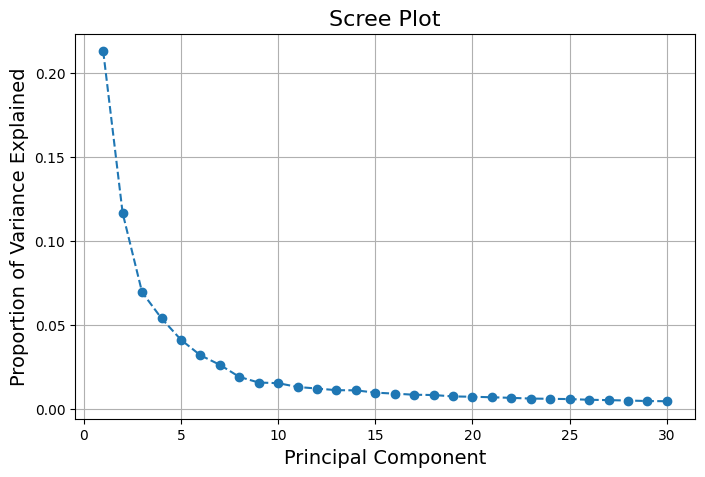

In [36]:
plt.figure(figsize=(8,5))
component_indices = np.arange(1, len(explained_variance_ratio)+1)

plt.plot(component_indices[0:30], explained_variance_ratio[0:30], marker='o', linestyle='--')
plt.xlabel('Principal Component', size=14)
plt.ylabel('Proportion of Variance Explained', size=14)
plt.title('Scree Plot', size=16)
plt.grid(True)
plt.show()

In [43]:
pca_df = pd.DataFrame(X_pca)
pca_df = pca_df.iloc[:, 0:11]
pca_df

,0,1,2,3,4,5,6,7,8,9,10
0,-6.482196,-5.347625,10.280538,6.526758,8.554959,10.865449,-8.041398,-1.292696,-3.882434,12.127211,-1.233784
1,-7.098763,-4.206194,4.466610,3.167461,6.634867,12.683917,-9.528985,-3.180528,-3.674002,7.012960,0.814117
2,-7.596407,-3.756945,2.240158,1.890015,6.326312,13.364122,-10.588622,-3.444943,-4.128918,5.738987,0.330635
3,-7.863728,-3.463970,0.753745,1.087606,6.021702,13.974751,-11.059535,-3.660449,-4.368666,4.956212,0.187090
4,-8.175047,-3.133410,-0.882020,0.158945,5.882947,14.429773,-12.129856,-4.297037,-4.685214,3.802940,0.363468
...,...,...,...,...,...,...,...,...,...,...,...
320656,-6.935881,-7.170741,4.660684,-5.734167,4.783068,-6.498935,1.696144,0.598796,-2.769574,-1.421481,2.392764
320657,-6.992530,-7.065161,4.465970,-5.795769,4.777046,-6.264601,1.390121,0.476311,-2.928226,-1.686843,2.229324
320658,-7.079406,-7.022705,4.257203,-5.982911,4.812639,-6.320634,0.961688,0.372332,-3.050123,-2.009771,2.171433
320659,-6.910435,-7.141739,3.902034,-6.491854,4.441893,-9.682758,2.810292,0.117794,-1.850120,-0.828987,3.140253


In [46]:
for i in range(0, 11):
    pca_df = pca_df.rename(columns={i:f'climate_risk_pca_{i+1}'})

pca_df

,climate_risk_pca_1,climate_risk_pca_2,climate_risk_pca_3,climate_risk_pca_4,climate_risk_pca_5,climate_risk_pca_6,climate_risk_pca_7,climate_risk_pca_8,climate_risk_pca_9,climate_risk_pca_10,climate_risk_pca_11
0,-6.482196,-5.347625,10.280538,6.526758,8.554959,10.865449,-8.041398,-1.292696,-3.882434,12.127211,-1.233784
1,-7.098763,-4.206194,4.466610,3.167461,6.634867,12.683917,-9.528985,-3.180528,-3.674002,7.012960,0.814117
2,-7.596407,-3.756945,2.240158,1.890015,6.326312,13.364122,-10.588622,-3.444943,-4.128918,5.738987,0.330635
3,-7.863728,-3.463970,0.753745,1.087606,6.021702,13.974751,-11.059535,-3.660449,-4.368666,4.956212,0.187090
4,-8.175047,-3.133410,-0.882020,0.158945,5.882947,14.429773,-12.129856,-4.297037,-4.685214,3.802940,0.363468
...,...,...,...,...,...,...,...,...,...,...,...
320656,-6.935881,-7.170741,4.660684,-5.734167,4.783068,-6.498935,1.696144,0.598796,-2.769574,-1.421481,2.392764
320657,-6.992530,-7.065161,4.465970,-5.795769,4.777046,-6.264601,1.390121,0.476311,-2.928226,-1.686843,2.229324
320658,-7.079406,-7.022705,4.257203,-5.982911,4.812639,-6.320634,0.961688,0.372332,-3.050123,-2.009771,2.171433
320659,-6.910435,-7.141739,3.902034,-6.491854,4.441893,-9.682758,2.810292,0.117794,-1.850120,-0.828987,3.140253


In [52]:
features_df = mergedf.join(pca_df)
features_df

ID                crop_name  \
0       8308c20c-d655-4500-b41a-af7b2dd8b255  Corn: Commodity Tracked   
1       c6e315ff-6f9e-436d-9cb9-a2ad08b50c78  Corn: Commodity Tracked   
2       3e01ae6b-350a-49d5-b6d4-a6939034a280  Corn: Commodity Tracked   
3       719fa75b-e4b6-4d0c-ade7-fc14c8a43c49  Corn: Commodity Tracked   
4       06335569-7672-4ed5-b425-712d084826d0  Corn: Commodity Tracked   
...                                      ...                      ...   
320656  fae8b98a-f698-4f21-8db1-99d378b21e40  Corn: Commodity Tracked   
320657  3332c221-5f37-4092-b61d-9594da431479  Corn: Commodity Tracked   
320658  2cfa035b-7891-4acd-8081-e9e25f50bae7  Corn: Commodity Tracked   
320659  31328318-72ed-40ec-a31e-702e69e2d2ea  Corn: Commodity Tracked   
320660  7f02e60d-85ad-47ad-886e-84463d211255  Corn: Commodity Tracked   

       country_name country_code  region_name  \
0          Paraguay           PY  Alto Paraná   
1          Paraguay           PY  Alto Paraná   
2          Paraguay           PY  Alto Paraná   
3          Paraguay           PY  Alto Paraná   
4          Paraguay           PY  Alto Paraná   
...             ...          ...          ...   
320656       Mexico           MX    Zacatecas   
320657       Mexico           MX    Zacatecas   
320658       Mexico           MX    Zacatecas   
320659       Mexico           MX    Zacatecas   
320660       Mexico           MX    Zacatecas   

                                   region_id harvest_period  \
0       6a4dabfc-c598-44e0-9d99-ea9e31d110cb       Planting   
1       6a4dabfc-c598-44e0-9d99-ea9e31d110cb       Planting   
2       6a4dabfc-c598-44e0-9d99-ea9e31d110cb       Planting   
3       6a4dabfc-c598-44e0-9d99-ea9e31d110cb       Planting   
4       6a4dabfc-c598-44e0-9d99-ea9e31d110cb       Planting   
...                                      ...            ...   
320656  42075985-d0c8-4d2c-af41-a9efaa6826e7   Peak Harvest   
320657  42075985-d0c8-4d2c-af41-a9efaa6826e7   Peak Harvest   
320658  42075985-d0c8-4d2c-af41-a9efaa6826e7   Peak Harvest   
320659  42075985-d0c8-4d2c-af41-a9efaa6826e7   Peak Harvest   
320660  42075985-d0c8-4d2c-af41-a9efaa6826e7   Peak Harvest   

        growing_season_year     date_on  \
0                      2016  2016-01-01   
1                      2016  2016-01-02   
2                      2016  2016-01-03   
3                      2016  2016-01-04   
4                      2016  2016-01-05   
...                     ...         ...   
320656                 2026  2025-12-11   
320657                 2026  2025-12-12   
320658                 2026  2025-12-13   
320659                 2026  2025-12-14   
320660                 2026  2025-12-15   

        climate_risk_cnt_locations_heat_stress_risk_low  \
0                                                    10   
1                                                    10   
2                                                    10   
3                                                    10   
4                                                    10   
...                                                 ...   
320656                                                1   
320657                                                1   
320658                                                1   
320659                                                1   
320660                                                1   

        climate_risk_cnt_locations_heat_stress_risk_medium  \
0                                                       0    
1                                                       0    
2                                                       0    
3                                                       0    
4                                                       0    
...                                                   ...    
320656                                                  0    
320657                                                  0    
320658                             

#### 1.6 Baseline features CFCS score

In [53]:
corrtable = compute_partial_correlations(features_df)
## compute cfcs score using backtesting functionalities
# 9m 31.9s for 1231 columns

In [55]:
sigcorr_report(corrtable).sort_values(by='avg_sig_corr', ascending=False).head(20)

,avg_sig_corr,max_sig_corr,sig_corr_count,sig_corr_ratio(%)
climate_variable,,,,
climate_risk_coldwave_max_40d_thresh_mag,0.700,0.782,13,0.814
climate_risk_coldwave_max_60d_thresh_mag,0.671,0.781,24,1.486
climate_risk_drought_ma_120d_thresh_mag,0.626,0.781,10,0.964
climate_risk_coldwave_max_40d_supply_weighting,0.624,0.624,1,0.051
climate_risk_coldwave_ma_14d,0.622,0.632,2,0.110
climate_risk_coldwave_max_90d_thresh_mag,0.621,0.825,24,1.384
climate_risk_coldwave_max_14d_thresh_mag,0.619,0.757,6,0.447
climate_risk_coldwave_ma_14d_log1p,0.619,0.629,2,0.110
climate_risk_excess_precip_max_240d_log1p,0.611,0.800,58,2.585


In [56]:
cfcs(corrtable)

0.25% of all correlations are significant
Average significant correlation is 0.558
highest absolute correlation found is 0.825
final CFCS score is 52.7


{'cfcs_score': np.float64(52.70155072835254),
 'avg_sig_score': np.float64(55.77753719680937),
 'max_corr_score': np.float64(82.54),
 'sig_count_score': 0.25391064973929}

In [32]:
features_sig = [
'climate_risk_coldwave_max_40d_thresh_mag',
'climate_risk_coldwave_max_60d_thresh_mag',
'climate_risk_coldwave_max_90d_thresh_mag',
'climate_risk_excess_precip_max_240d_log1p',
'climate_risk_excess_precip_max_240d_ssqrt',
'climate_risk_excess_precip_max_240d',
'climate_risk_drought_ma_90d',
'climate_risk_drought_ma_60d',
'climate_risk_drought_ma_120d',	
'climate_risk_excess_precip_max_7d',
'climate_risk_coldwave_max_40d_supply_weighting',
]	

submissiondf = mergedf.dropna()
submissiondf = submissiondf[submissiondf.columns[pd.Series(submissiondf.columns).apply(\
lambda x:( not x.startswith('climate_risk')) or (x in features_sig)
)]]

In [ ]:
features_sig = [
'climate_risk_coldwave_max_40d_thresh_mag',
'climate_risk_coldwave_max_60d_thresh_mag',
'climate_risk_coldwave_max_90d_thresh_mag',
'climate_risk_excess_precip_max_240d_log1p',
'climate_risk_excess_precip_max_240d_ssqrt',
'climate_risk_excess_precip_max_240d',
'climate_risk_drought_ma_90d',
'climate_risk_drought_ma_60d',
'climate_risk_drought_ma_120d',	
'climate_risk_excess_precip_max_7d',
'climate_risk_coldwave_max_40d_supply_weighting',
]	

submissiondf = mergedf.dropna()
submissiondf = submissiondf[submissiondf.columns[pd.Series(submissiondf.columns).apply(\
lambda x:( not x.startswith('climate_risk')) or (x in features_sig)
)]]

In [33]:
corrtable_1 = compute_partial_correlations(submissiondf)

In [34]:
cfcs(corrtable_1)

2.17% of all correlations are significant
Average significant correlation is 0.615
highest absolute correlation found is 0.825
final CFCS score is 55.93


{'cfcs_score': np.float64(55.93372072337707),
 'avg_sig_score': np.float64(61.4741604010025),
 'max_corr_score': np.float64(82.54),
 'sig_count_score': 2.173202614379085}